In [64]:
from __future__ import division, absolute_import, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [65]:
import os
import sys
import importlib
module_path = os.path.abspath(os.path.join('../soft/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import republic_versions as rv
import republic_v1 as rv1

## Simple systematics, stellar variability and box-shaped transits

### Time array

In [66]:
Kp = 1000 # time range
step = 1  # time step
K = int(Kp/step) # no observations
t = np.arange(K)[::step] # time array

### Simulate stellar light curve 

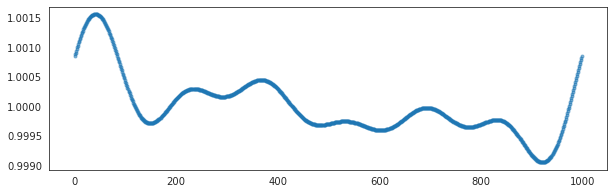

In [190]:
M = 6
importlib.reload(rv)
A_basis = rv.mk_basis(t, M, basis = 'fourier', include_bias = False, doplot=False, normalise = True)
M = A_basis.shape[0]
a = np.random.uniform(size=M) / M
A_true = np.dot(a,A_basis) * 0.003 + 1
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0.-',lw=0.5,alpha=0.5)

### Add transits

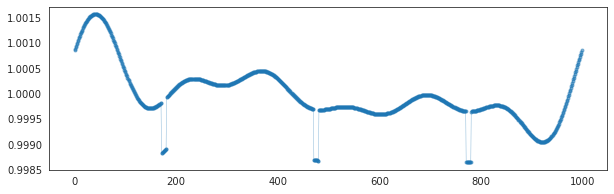

In [191]:
ptr = 300
t0tr = 175
dutr = 10
detr = 0.001
phtr = ((t-t0tr)%ptr)/ptr
phtr[phtr>0.5] -= 1
l = abs(phtr) <= (dutr/ptr/2)
A_true[l] *= 1-detr
#amin, amax = A_true.min(), A_true.max()
#A_true = (A_true - amin) / (amax - amin) - 0.5
#A_true -= 1
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0.-',lw=0.5,alpha=0.5)

### Simulate systematics trends

importlib.reload(rv)
N_in = 2    # number of trends per camera
s = np.zeros_like(t, 'int')
s[int(Kp/2):]=1
importlib.reload(rv)
T_basis = rv.mk_segmented_basis(t, s, N_in, basis = 'poly', include_bias = True, normalise=True, doplot=False)
N = T_basis.shape[0]
plt.figure(figsize=(10,3))
plt.plot(t,T_basis.T,'-',lw=0.5,alpha=0.5);

### Contruct 24 realisations of the light curve 
with different systematrics, white noise, and biases

J = 24   # number of cameras
w_true = np.random.uniform(low=-0.5,high=0.5,size=(J,N))*0.1
sig = np.random.uniform(0.1,0.1,J)*0.02
F = np.zeros((J,K))
sigma = np.zeros_like(F)
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0-')
for j in range(J):
    F[j,:] = A_true + np.dot(w_true[j,:], T_basis) + np.random.normal(scale=sig[j],size=K)
    sigma[j,:] = sig[j]
    plt.plot(t,F[j,:],'C1-',lw=0.5,alpha=.3)
    print(np.mean(F[j,:]),np.var(F[j,:]))
    
Fm = np.mean(F,axis=0)
plt.plot(t,Fm,'C2-',lw=0.5)


### Extract basis of trends from Kepler Q14 (DR25) CBV file

[30 42 22 46 15 13 28 59 50  0 14 20 68 70  8  7 12 83  3 32 54 69 52 75
 71 81 44 60  1 74 39 64 31 80 47 63 66 48 10 35 82 40 72 37 23 17 36 21
 61 33 19 51 24 55  4 38 29 73 45 25  5  6  9 67 49 56  2 58 78 26 76 65
 41 11 53 79 57 34 18 62 77 43 27 16]


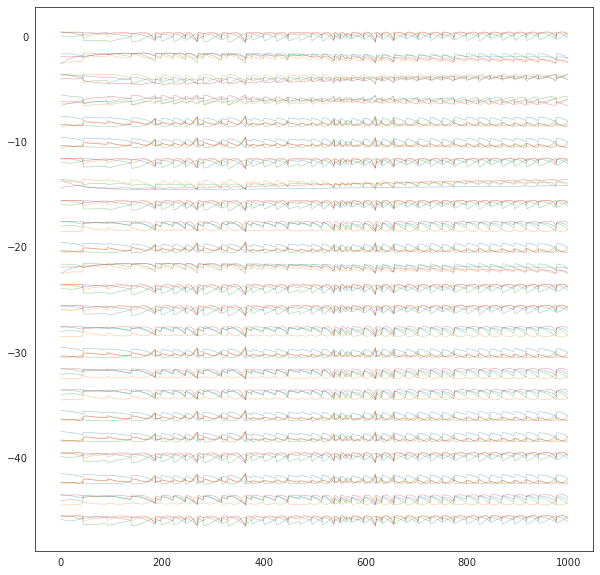

In [202]:
J = 24
N = 4
from astropy.io import fits as pf
from scipy.interpolate import interp1d
#hdul = pf.open('kplr2012277125453-q14-d25_lcbv.fits')
#hdul = pf.open('kplr2009259160929-q02-d25_lcbv.fits')
hdul = pf.open('ktwo-c05-d31_lcbv.fits')
J_Kep = len(hdul)-1
j = 0
plt.figure(figsize=(10,10))
jj = np.arange(J_Kep).astype(int)
np.random.shuffle(jj)
print(jj)
T_true = np.ones((J,K,N+2)) # basis matrix - allow for 1 bias term per camera
for jk in jj:
    d = hdul[jk+1].data
    if len(d['VECTOR_1']) == 0: # empty MODOUT
        continue
    l = np.where(d['GAPFLAG'] == 0)[0][:Kp:step]
    for n in range(N):
        v = d['VECTOR_{}'.format(n+1)][l]
        vmin, vmax = np.nanmin(v), np.nanmax(v)
        v = (v-vmin) / (vmax-vmin) - 0.5
        ll = np.isfinite(v)
        vv = interp1d(t[ll],v[ll])(t)
        T_true[j,:,n] = vv
        plt.plot(t,T_true[j,:,n]-2*j,'C{}-'.format(n),lw=0.5,alpha=0.5)
#    plt.plot(t,T_true[j,:,N]-2*j,'C{}-'.format(N),lw=0.5,alpha=0.5)
    j += 1
    if j == J: # that's enough
        break
hdul.close()
T_true[:,:,N:] = 0.1
N += 2

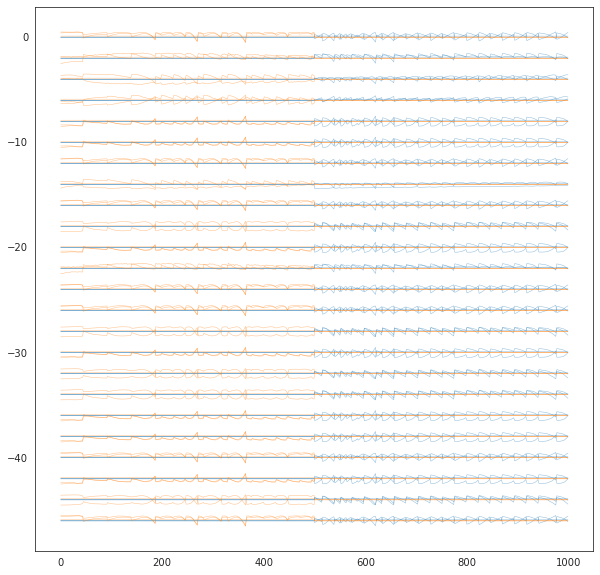

In [203]:
s = np.zeros_like(t, 'int')
s[int(Kp/2):]=1
su = np.unique(s)
plt.figure(figsize=(10,10))
for si,ss in enumerate(su):
    l = s == ss
    for j in range(J):
        T_true[j,l,si::2] = 0
        plt.plot(t,T_true[j,:,si::2]-2*j,'C{}-'.format(si),lw=0.5,alpha=0.5)


### Contruct 24 realisations of the light curve 
with different systematrics, white noise, and biases

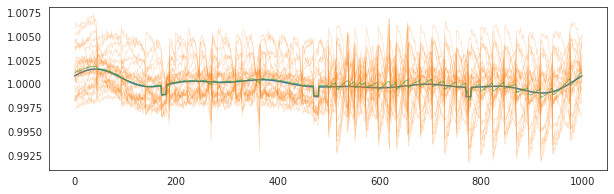

In [204]:
w_true = np.random.uniform(low=-0.1,high=0.1,size=(J,N)) * 0.1
sig = 0.0002
F = np.zeros((J,K))
sigma = np.zeros_like(F)
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0-')
for j in range(J):
    sigma[j,:] = sig 
    F[j,:] = A_true + np.random.normal(scale=sig,size=K)
    for n in range(N):
        #print(j,n,W[j,n],np.nanmin(B[:,j,n]),np.nanmax(B[:,j,n]))
        F[j,:] += w_true[j,n] * T_true[j,:,n]
    plt.plot(t,F[j,:],'C1-',lw=0.5,alpha=.3)
Fm = np.mean(F,axis=0)
plt.plot(t,Fm,'C2-',lw=0.5)
s = np.zeros_like(t, 'int')


In [205]:
Np = N 
T_use = np.zeros((J,K,Np))
for j in range(J):
    #T_use[j,:,:] = T_basis[:Np,:].T# + np.random.normal(scale=0.01, size=(K,Np))
    T_use[j,:,:] = T_true[j,:,:Np]# + np.random.normal(scale=0.01, size=(K,Np))
        

kl = np.isfinite(F).sum(axis=0)
F = F[:,kl]
sigma = sigma[:,kl]
T_use = T_use[:,kl,:]
A_true = A_true[kl]

# Try corrections

PDC-LS
rep1
No cameras: 24
No frames: 1000
Using basis type eye for stellar signal.
No free params for stellar signal 1000
Using user-supplied systematic basis
No trends per camera: 6
No free params for systematics: 144
Condition no. of E: 13138616.84677507
Condition no. of X: 9.481682906340456e+17
Condition no. of E_DTCinvD: 3.588892085749226e+17
[-0.546875 -0.5      -0.234375 -0.0625   -0.171875 -0.21875  -0.203125
 -0.15625  -0.296875 -0.125   ]
[  -4.57121088 -666.70241214  -10.25       -202.5          14.46834093
   -6.21137826   11.2365982    10.74964223  -30.25        -22.5       ]
rep2
No cameras: 24
No frames: 1000
Using basis type fourier for stellar signal.
No free params for stellar signal 24
Condition no. of C: 4.089563229854987
Using functional basis for systematics
Basis type: poly
No trends per camera: 3
No free params for systematics: 72
Condition no. of E: 1.0000000000000002
Condition no. of X: 24063787657.538254
Condition no. of E_DTCinvD: 35282799.88859038
[-4.66074

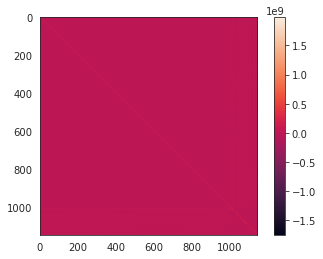

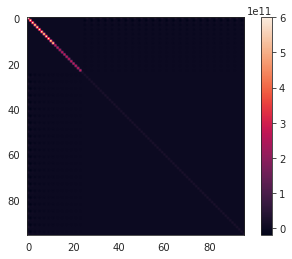

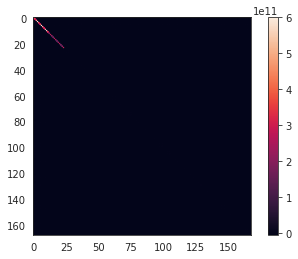

In [206]:
importlib.reload(rv)
importlib.reload(rv1)
N_in = 2
star_basis = 'fourier'
sys_basis = 'poly'
print('PDC-LS')
_, Fc_pdcls, Fc_av = rv.pdc_ls(F, T_use, sigma)    
print('rep1')
_, Fc_rep1, Star_rep1, _, _ = rv.republic(t, F, sigma, T = T_use, s = s, star_basis_type = 'eye')
print('rep2')
_, Fc_rep2, Star_rep2, _, _ = rv.republic(t, F, sigma, T = None, s = s , \
                                          star_basis_type = star_basis, L_in = M, \
                                          sys_basis_type = sys_basis, N_in = N_in, \
                                          lambda_reg = 1)
print('rep3')
_, Fc_rep3, Star_rep3, _, _ = rv.republic(t, F, sigma, T = T_use, s = s, \
                                          star_basis_type = star_basis, L_in = M, \
                                          lambda_reg = 1)

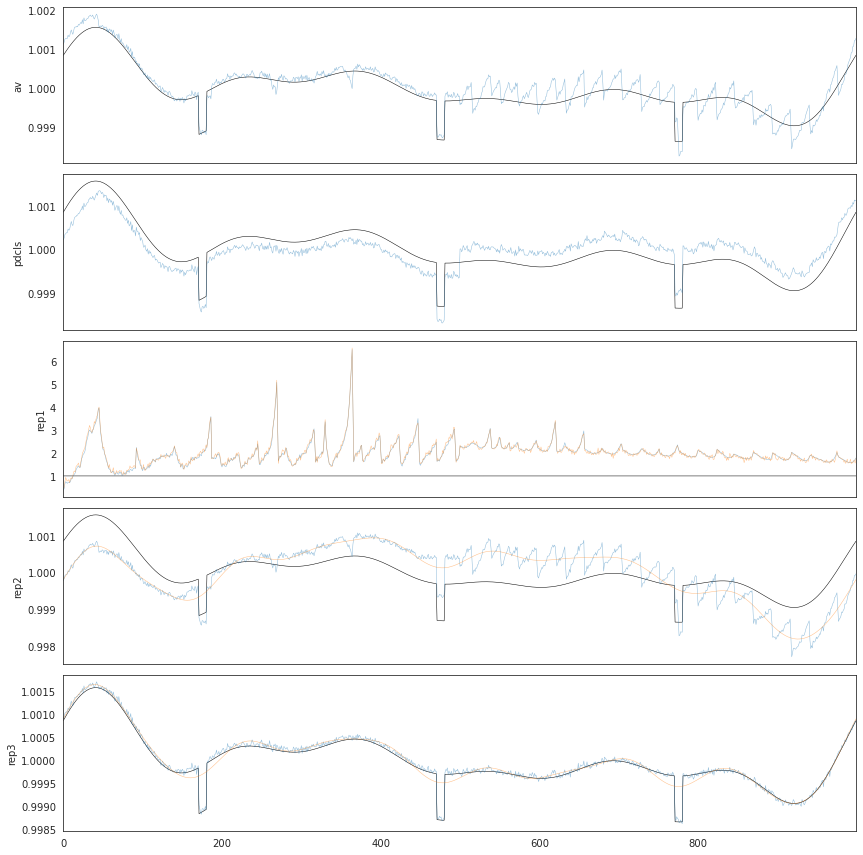

In [208]:
fig,axes=plt.subplots(5,1,figsize=(12,12),sharex=True, sharey=False)
axes[0].plot(t,A_true,'k-',lw=0.5)
axes[1].plot(t,A_true,'k-',lw=0.5)
axes[2].plot(t,A_true,'k-',lw=0.5)
axes[3].plot(t,A_true,'k-',lw=0.5)
axes[4].plot(t,A_true,'k-',lw=0.5)
axes[0].plot(t,Fc_av,'C0-',lw=0.5, alpha=0.5)
axes[1].plot(t,Fc_pdcls+1,'C0-',lw=0.5, alpha=0.5)
axes[2].plot(t,Fc_rep1+1,'C0-',lw=0.5, alpha=0.5)
axes[2].plot(t,Star_rep1+1,'C1-',lw=0.5, alpha=0.5)
axes[3].plot(t,Fc_rep2+1,'C0-',lw=0.5, alpha=0.5)
axes[3].plot(t,Star_rep2+1,'C1-',lw=0.5, alpha=0.5)
axes[4].plot(t,Fc_rep3+1,'C0-',lw=0.5, alpha=0.5)
axes[4].plot(t,Star_rep3+1,'C1-',lw=0.5, alpha=0.5)
axes[0].set_ylabel('av')
axes[1].set_ylabel('pdcls')
axes[2].set_ylabel('rep1')
axes[3].set_ylabel('rep2')
axes[4].set_ylabel('rep3')
plt.xlim(t.min(),t.max())
#plt.xlim(400,600)
plt.tight_layout();

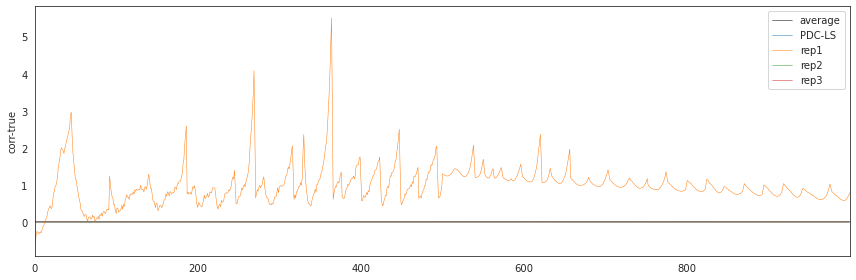

In [220]:
fig,axes=plt.subplots(1,1,figsize=(12,4))
axes.plot(t,Fc_av-A_true,'k-',lw=0.5, label='average')
axes.plot(t,Fc_pdcls-A_true+1,'C0-',lw=0.5, label='PDC-LS')
axes.plot(t,Fc_rep1-A_true+1,'C1-',lw=0.5, label='rep1')
axes.plot(t,Fc_rep2-A_true+1,'C2-',lw=0.5, label='rep2')
axes.plot(t,Fc_rep3-A_true+1,'C3-',lw=0.5, label='rep3')
axes.legend(loc=0)
axes.set_ylabel('corr-true')
plt.xlim(t.min(),t.max())
#plt.ylim(-0.002,0.002)
plt.tight_layout();

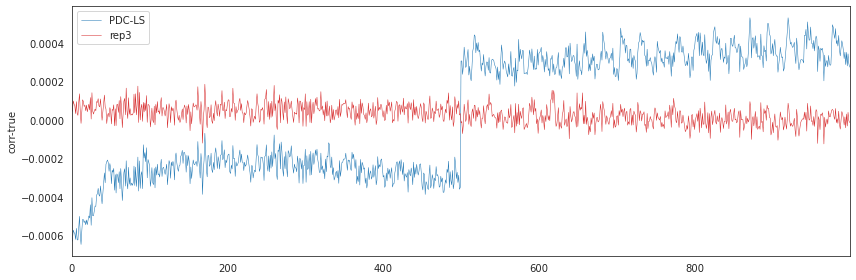

In [221]:
fig,axes=plt.subplots(1,1,figsize=(12,4))
axes.plot(t,Fc_pdcls-A_true+1,'C0-',lw=0.5, label='PDC-LS')
axes.plot(t,Fc_rep3-A_true+1,'C3-',lw=0.5, label='rep3')
axes.legend(loc=0)
axes.set_ylabel('corr-true')
plt.xlim(t.min(),t.max())
#plt.ylim(-0.002,0.002)
plt.tight_layout();